In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#from ngts_functions import *
import matplotlib.pyplot as plt
import numpy as np
import pythonFunctions as pfunc
#from astropy.timeseries import LombScargle
# from scipy.optimize import minimize
# from astropy.io import fits
#import bz2
#import os
# import celerite
# from celerite import terms
# from ngts_functions import *
#from matplotlib.gridspec import GridSpec
#from matplotlib import lines

# from transitleastsquares import transitleastsquares
# from wotan import flatten
# import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

%matplotlib notebook 

ModuleNotFoundError: No module named 'celerite2'

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.minor.visible' : True}
pylab.rcParams.update(params)

In [4]:
save_plots = '/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/'
def run_GP(time, flux, flux_err):
    t_model = np.linspace(time.min(), time.max(), int(time.size*5))
    with pm.Model() as model:
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=np.mean(flux), sigma=np.nanstd(flux))

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.nanmedian(flux_err)), sigma=5.0)

        #A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(per), sigma=np.log(2))
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
       # kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1/np.sqrt(2.0))
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=time,
            diag=flux_err**2 + log_jitter**2,
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=flux)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(flux))
        
        # Compute the mean model prediction for plotting purposes with different time candences
        pm.Deterministic("pred_t_model", gp.predict(flux, t=t_model))
        #pm.Deterministic("pred_t_transits", gp.predict(flux, t=full_time))
        
        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize(verbose=False)
    
    return model, gp, map_soln, t_model
## ==================================== ##

def GP_clipping(data, map_soln):
    '''
    MAP GP model based sigma clipping. Estimate the maximum a posteriori GP and clip data points which are nsig larger than model
    Return: Clipped data and indexes of all removed data
    '''
    
    #compute sigma clipping on residuals
    time, flux, flux_err = data
    data_clipped = pfunc.sigma_clipping(time, flux - map_soln["pred"], flux_err, nsig=3, niter=10, mask_id=True)
    try:
        idx_mask = data_clipped[3]
    except IndexError:
        idx_mask = []
        
    return idx_mask
##=====================================##

def plot_corner():
    results = trace.to_dict()
    labels = []
    corner_data = []
    for i in results['posterior'].keys():
        if i not in np.array(list(results['posterior'].keys()))[-3:]:
            labels.append(i)
            corner_data.append(list(results['posterior'][i][1]))

    corner_data = np.vstack(corner_data).T
    figure = corner.corner(data, labels=labels)
    
    plt.savefig(save_plots + f'star_{star}_corner.png')
    plt.close('all')

    
def plot_lcs(data, save_plot=True):
    results = trace.to_dict()
    model_50q = np.median(results['posterior']['pred_t_model'][:, :, :], axis=[0,1])#np.median(results['posterior']['pred_t_model'][0, :, :], axis=-2)
    model_1sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [16,84], axis=[0,1])
    model_2sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [2.5,97.5], axis=[0,1])#np.percentile(results['posterior']['pred_t_model'][0, :, :], [2.5,97.5], axis=-2)
    model_3sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [0.2,99.8], axis=[0,1])#np.percentile(results['posterior']['pred_t_model'][0, :, :], [0.2,99.8], axis=-2)
    
    #Ploting tools
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(20,4), gridspec_kw={'width_ratios':[3, 1.5, 1]})
    ax.plot(data[0][idx_masked_fluxes]-tmin, (data[1][idx_masked_fluxes]/mu -1)*1e3, color = 'gray', marker='.', linestyle = '', label="outliers")
    ax.plot(time, flux, color = 'black', marker='.', linestyle = '', alpha=0.8, label='data')
    ax.plot(t_model, model_50q, color="red")
    ax.fill_between(t_model, *model_1sig, color="red", alpha=0.3)
    ax.fill_between(t_model, *model_2sig, color="red", alpha=0.2)
    ax.fill_between(t_model, *model_3sig, color="red", alpha=0.1)
    
    #ax.plot(t_model, map_soln["pred_t_model"], color="red", label="MAP model", linewidth=2, alpha=0.7)

    # ax.legend(fontsize=10)
    ax.set_xlabel("time (days)")
    #ax.set_xlim(-0.1, 220)
    ax.set_ylabel("relative flux (ppt)")
    ax.minorticks_on()


    period_samples = np.asarray(trace.posterior["period"]).flatten()
    folded_t = time/np.median(period_samples) %1
    sorted_t = np.argsort(folded_t)
    # Phase folded
    ax2.scatter(folded_t, flux, c=time, cmap='viridis', s=10, alpha=0.8, label=f'P={np.median(period_samples):.2f}  days', vmax=time[time<250].max())
    argsort_model = np.argsort(folded_t)
#     ax2.plot(folded_t[argsort_model], model_50q[argsort_model], color="red", label=f'P={np.median(period_samples):.2f} d', alpha=0.3)
    ax2.set_ylabel("relative flux (ppt)")
    ax2.set_xlabel("Phase")
    ax2.legend()
    ax2.minorticks_on()

    # Period distribution
    ax3.hist(period_samples, 25, histtype="step", color="red", density=True)
    # For label purposes
    handles = []
    for p,c in zip([per, acf_per], ['C0', 'C4']):
        ax3.axvspan(p-1e-6, p+1e-6, color=c, label='LS' if c=='C0' else 'ACF')
        vertical_line = lines.Line2D([], [],  marker='|', linestyle='None', color=c,
                                 markersize=10, markeredgewidth=1.5)
        handles.append(vertical_line)
    _, labels = ax3.get_legend_handles_labels()

    ax3.legend(handles, labels)
    ax3.minorticks_on()
    ax3.set_yticks([])
    ax3.set_xlabel("Rotation period [days]")
    ax3.set_ylabel("PDF")

    fig.suptitle(f'NGTS star id: {star}, TIC ID: {tic_ids[num]}, Teff: {int(Teffs[num])} K, Gmag: {Gmags[num]:.2f}')
    plt.tight_layout()
        
    if save_plot:
        plt.savefig(save_plots + f'star_{star}_rot.png')
        plt.close('all')
        
def planet_search():
    # prepare 5 min data
    mu_5min = np.mean(data_5min[1])
    flux_5min = (data_5min[1]/mu_5min -1)*1e3
    flux_err_5min = data_5min[2] * 1e3 / mu_5min # in ppt
    time_5min = data_5min[0]
    
    #Get median GP model
    results = trace.to_dict()
    model_50q = np.median(results['posterior']['pred_t_5min'][:, :, :], axis=[0,1])#np.median(results['posterior']['pred_t_5min'][0, :, :], axis=-2)
    
    # Sigma clip residuals
    data_search = pfunc.sigma_clipping(time_5min - time_5min.min(), flux_5min - model_50q, flux_err_5min, nsig=3.0, niter=10, mask_id=True)
    # Normalised OC
    f_search = (data_search[1] + mu_5min)/np.mean(data_search[1] + mu_5min)
    
    _ = pfunc.run_tls(data_search[0] - data_search[0].min(), f_search, period_min=0.6, period_max=30, save_plots=True,
                      path=save_plots+'/GP_planet_search/' + f'star_{star}_Psearch', name='', use_threads=14, remove_alias_freq=True)
    
    np.savetxt(save_plots+'/GP_planet_search/' + f'star_{star}_lc.txt', np.vstack([time_5min - time_5min.min(), data_5min[1], data_5min[2],model_50q]),
              header = 'time [days]    flux    flux_err    GP_model(ppt)', delimiter='\t')
    plt.close('all')

In [5]:
# Load data
tess_data_S04 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/tess_spoc04_norm.txt').T
tess_data_S33 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/tess_spoc33_norm.txt').T
tess_data_S34 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/tess_spoc34_norm.txt').T
# QLP data
# tess_data_S04 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/qlp04_norm.txt').T
# tess_data_S33 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/qlp33_norm.txt').T
# tess_data_S33 = np.delete(tess_data_S33, tess_data_S33[1] < 0.8, axis=1)
# tess_data_S34 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/qlp34_norm.txt').T
# tess_data_S34 = np.delete(tess_data_S34, tess_data_S34[1] < 0.8, axis=1)
tess_data_S61 = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/qlp61_norm.txt').T
#NGTS data
ngts_data = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/data/NOI-106557_NGTS.dat').T

tess_data_S04[0] += 2457000
tess_data_S33[0] += 2457000
tess_data_S34[0] += 2457000
tess_data_S61[0] += 2457000

#bin it to 5 min 
tess_data_S61_bin = np.array(pfunc.bin_data(*tess_data_S61, step=5./(60.*24.), avrg='median', normalize=False))
ngts_data = np.array(pfunc.bin_data(*ngts_data, step=5./(60.*24.), avrg='median', normalize=False))

tess_data = np.concatenate([tess_data_S04, tess_data_S33, tess_data_S34, tess_data_S61_bin], axis=1)
#tess_data = tess_data_S61_bin

In [6]:
# tess_data[-1] = np.ones(tess_data_S61[-1].size) * 0.001 # 0.001 median of tess S34 error (max of the 3 sectors)

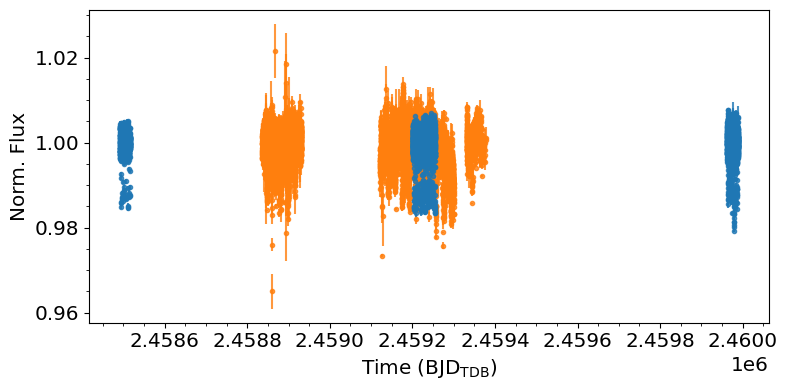

In [6]:
# Plot data
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.errorbar(*ngts_data, fmt='C1.', alpha=0.8)
ax.errorbar(*tess_data, fmt='C0.', alpha=0.8)
ax.set_xlabel(r'Time (BJD$_{\rm TDB}$)')
ax.set_ylabel('Norm. Flux')
ax.minorticks_on()
plt.tight_layout()

In [7]:
per, t0 = 2.827971, 2459986.408516
per_err, t0_err = 0.00000153, 0.00042659
rp, a, inc = 0.114788,6.921315,83.771997
rpe = 0.0012
#TESS
# oot_tess_data = pfunc.get_oot_lc(*tess_data, per=per, t0=t0, width=0.03)
# median = np.median(oot_tess_data[1])


# time, flux, flux_err = oot_tess_data
# time_all, flux_all, flux_err_all = tess_data


# #NGTS 
oot_ngts_data = pfunc.get_oot_lc(*ngts_data, per=per, t0=t0, width=0.020)
median = np.median(oot_ngts_data[1]) 

time, flux, flux_err = oot_ngts_data
time_all, flux_all, flux_err_all = ngts_data

<ErrorbarContainer object of 3 artists>

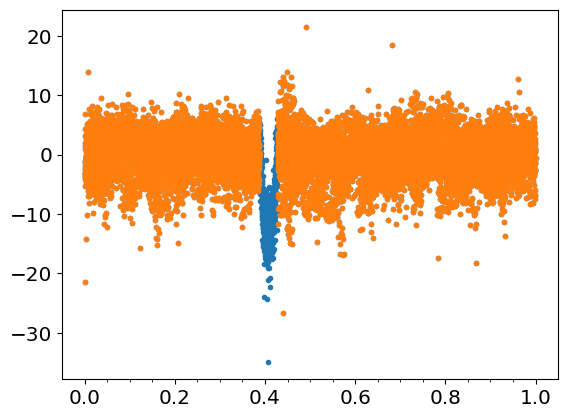

In [8]:
fig, ax = plt.subplots(1,1)

# ax.errorbar((tess_data[0]-0.5*t0)/per %1,(tess_data[1]/median -1)*1e3,tess_data[2]/median, fmt='.')
# ax.errorbar((oot_tess_data[0]-0.5*t0)/per %1,(oot_tess_data[1]/median -1)*1e3,oot_tess_data[2]/median, fmt='.')

# fig, ax = plt.subplots(1,1)

ax.errorbar((ngts_data[0]-0.5*t0)/per %1,(ngts_data[1]/median -1)*1e3,ngts_data[2]/median, fmt='.')
ax.errorbar((oot_ngts_data[0]-0.5*t0)/per %1,(oot_ngts_data[1]/median -1)*1e3,oot_ngts_data[2]/median, fmt='.')

In [9]:
# GP_sigma_TESS        loguniform           1e-06,1000000.0     
# GP_rho_TESS          loguniform           0.001,1000.0

In [11]:
t_model = np.linspace(time.min(), time.max(), int(time.size*5))
prot=0.677
prot_sig = 1
with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(flux), sigma=np.nanstd(flux))

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.nanmedian(flux_err)), sigma=5.0)

    #A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    sigma = pm.Uniform("log_sigma", lower=np.log(1e-06),upper=np.log(1_000_000))
    
    rho = pm.Uniform("log_rho", lower=np.log(0.001),upper=np.log(1_000))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
#     log_period = pm.Normal("log_period", mu=np.log(prot), sigma=np.log(prot_sig))
    log_period = pm.Uniform("log_period", lower=np.log(0.2), upper=np.log(30))
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=1.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=tt.exp(sigma), rho=tt.exp(rho), Q=1/np.sqrt(3.0))
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=time,
        diag=flux_err**2 + log_jitter**2,
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux))

    # Compute the mean model prediction for plotting purposes with different time candences
    pm.Deterministic("pred_t_model", gp.predict(flux, t=t_model))
    pm.Deterministic("pred_t_transits", gp.predict(flux, t=time_all))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(verbose=False)

    with model:

        trace = pmx.sample(
            tune=500,
            draws=2000,
            start=map_soln,
            cores=12,
            chains=4,
            target_accept=0.9,
            return_inferencedata=True
        )

KeyboardInterrupt: 

In [ ]:
# MCMC results
results = trace.to_dict()
model_50q = np.median(results['posterior']['pred_t_model'][:, :, :], axis=[0,1])#np.median(results['posterior']['pred_t_model'][0, :, :], axis=-2)
model_1sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [16,84], axis=[0,1])
model_2sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [2.5,97.5], axis=[0,1])#np.percentile(results['posterior']['pred_t_model'][0, :, :], [2.5,97.5], axis=-2)
model_3sig = np.percentile(results['posterior']['pred_t_model'][:, :, :], [0.2,99.8], axis=[0,1])#np.percentile(results['posterior']['pred_t_model'][0, :, :], [0.2,99.8], axis=-2)
# evaluated on full data
model_50q_full = np.median(results['posterior']['pred_t_transits'][:, :, :], axis=[0,1])#np.median(results['posterior']['pred_t_model'][0, :, :], axis=-2)

In [ ]:
# Get transits TESS
# Tdur = pfunc.transit_dur(per=per, rp=rp, a=a, inc=inc) # in days
# Ti, Te, T0_first = pfunc.linear_ephemerides(T0=t0, T0err=t0_err, P=per, Perr=per_err, Tdur=Tdur, Tdurerr=0.0, dt=0.0, time=tess_data[0])

# Get transits NGTS
Tdur = pfunc.transit_dur(per=per, rp=rp, a=a, inc=inc) # in days
Ti, Te, T0_first_NGTS = pfunc.linear_ephemerides(T0=t0, T0err=t0_err, P=per, Perr=per_err, Tdur=Tdur, Tdurerr=0.0, dt=0.0, time=ngts_data[0])

In [ ]:
# Tdur_e = pfunc.transit_dur(per=per+per_err, rp=rp+rpe, a=a, inc=inc) - Tdur 

In [10]:
# Juliet detrended data
# tess_data = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/juliet_runs/run2_tess-qlp61_tightPriors_livepoints10k/TESS_GPmodeled.txt',
#                       delimiter=',').T


# # # Get transits TESS
# Tdur = pfunc.transit_dur(per=per, rp=rp, a=a, inc=inc) # in days
# Ti, Te, T0_first = pfunc.linear_ephemerides(T0=t0, T0err=t0_err, P=per, Perr=per_err, Tdur=Tdur, Tdurerr=0.0, dt=0.0, time=tess_data[0])

ngts_data = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/juliet_runs/run2_tess-qlp61_tightPriors_livepoints10k/NGTS_GPmodeled.txt',
                      delimiter=',').T

# Get transits NGTS
Tdur = pfunc.transit_dur(per=per, rp=rp, a=a, inc=inc) # in days
Ti, Te, T0_first = pfunc.linear_ephemerides(T0=t0, T0err=t0_err, P=per, Perr=per_err, Tdur=Tdur, Tdurerr=0.0, dt=0.0, time=ngts_data[0])

Shifting T0 backwards 406 transits


In [11]:
#TESS
# t_transitTESS, f_transitTESS, ferr_transitTESS, NTESS = pfunc.select_full_transits(Ti, Te, per, 2, 100, False, *tess_data, plot=False)

# #Linear ephemerides based on t0.
# linear_ephTESS = T0_first + NTESS * per

#NGTS
Ti_NGTS, Te_NGTS, T0_first_NGTS = pfunc.linear_ephemerides(T0=t0, T0err=t0_err, P=per, Perr=per_err, Tdur=Tdur, Tdurerr=0.0, dt=0.0, time=ngts_data[0])
t_transitNGTS, f_transitNGTS, ferr_transitNGTS, NNGTS = pfunc.select_full_transits(Ti_NGTS, Te_NGTS, per, 10., 100, False, *ngts_data, plot=False)

##Linear ephemerides based on t0.
linear_ephNGTS = T0_first_NGTS + NNGTS * per

Shifting T0 backwards 406 transits


In [12]:
NNGTS = np.array([3,15,21,27,119,131,137]) #full transits
linear_ephNGTS = T0_first_NGTS + NNGTS * per

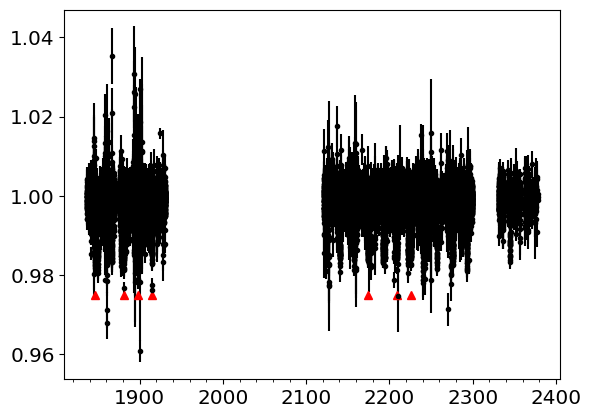

In [13]:
# fig, ax = plt.subplots(1,1)

# ax.errorbar(*tess_data, fmt='k.')
# ax.plot(linear_ephTESS, [0.975]*linear_ephTESS.size, 'r^')


fig, ax = plt.subplots(1,1)

ax.errorbar(ngts_data[0]-2457000, *ngts_data[1:], fmt='k.')
ax.plot(linear_ephNGTS-2457000, [0.975]*linear_ephNGTS.size, 'r^')


In [ ]:
# for i in range(NNGTS.size):
#     print(f'T_p1_NGTS_{NNGTS[i]}','\t normal','\t', f'{round(linear_ephNGTS[i],4)},0.05')

In [14]:
# #Ploting tools
# fig, (ax, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True, gridspec_kw={'height_ratios':[1, 1]})
# #ax.plot(data[0][idx_masked_fluxes]-tmin, (data[1][idx_masked_fluxes]/mu -1)*1e3, color = 'gray', marker='.', linestyle = '', label="outliers")
# # ax.errorbar(*tess_data, color = 'black', marker='.', linestyle = '', alpha=0.8, label='data')
# ax.errorbar(*ngts_data, color = 'black', marker='.', linestyle = '', alpha=0.8, label='data')
# ax.plot(t_model, model_50q, color="red")
# ax.fill_between(t_model, *model_1sig, color="red", alpha=0.3)
# ax.fill_between(t_model, *model_2sig, color="red", alpha=0.2)
# ax.fill_between(t_model, *model_3sig, color="red", alpha=0.1)


# ax2.errorbar(ngts_data[0], ngts_data[1] - model_50q_full + 1, ngts_data[2], fmt='k.')
# ax2.plot(linear_ephNGTS, [0.975]*linear_ephNGTS.size, 'r^')
# # ax2.errorbar(tess_data[0], tess_data[1] - model_50q_full + 1, tess_data[2], fmt='k.')
# # ax2.plot(linear_ephTESS, [0.975]*linear_ephTESS.size, 'r^')
# #ax2.errorbar(detr_data[0], detr_data[1], detr_data[2], fmt='g.')

# offset = 5/(24) # 5hr before/after transit
# # for i,j in zip(Ti, Te):
# #     ax2.vlines(i-offset,ymin=0, ymax=2, colors='g')
# #     ax2.vlines(j+offset,ymin=0, ymax=2, colors='b')

# # ax.legend(fontsize=10)
# fig.supylabel("Norm. flux")
# ax2.set_xlabel("time (days)")
# ax.set_ylim(0.97, 1.01)
# # ax2.set_ylabel("Norm. flux")
# ax.minorticks_on()


# plt.tight_layout()


In [ ]:
# # Detrended dat
# np.savetxt('/home/astropc/Desktop/detrent_sec61.dat', np.c_[tess_data[0], tess_data[1] - model_50q_full + 1, tess_data[2]], fmt='%s')
# np.savetxt('/home/astropc/Desktop/GP_model_sec61.dat', np.c_[t_model, model_50q, model_1sig[0], model_1sig[1], model_2sig[0],model_2sig[1],
#                                                           model_3sig[0], model_3sig[1]],
#            header='t_model model_50q model_1sig_low model_1sig_up model_2sig_low model_2sig_up model_3sig_low model_3sig_up', fmt='%s')

In [ ]:
# np.savetxt('/home/astropc/Desktop/celerit2_detrended_lc.dat', np.c_[tess_data[0], tess_data[1] - model_50q_full + 1, tess_data[2]], fmt='%s')

In [ ]:
# for i in range(NTESS.size):
#     print(f'T_p1_TESS_{NTESS[i]}','\t normal','\t', f'{round(linear_ephTESS[i],4)},0.05')

## MCMC for each T0 

In [ ]:
# # q1_TESS         	    0.285734    	  +0.06097220   	  -0.05936767   	[0.10274436, 0.405199]
# # q2_TESS         	    0.008577    	  +0.10075466   	  -0.02228228   	[0.00000817, 0.359431]
# u1 = lambda q1,q2: 2* np.sqrt(q1)*q2
# u2 = lambda q1,q2: np.sqrt(q1)*(1-2*q2)

In [ ]:
# u2(0.285734, 0.008577)

In [14]:
def f_batman(x, t0, rp,a,baseline):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0                     #time of inferior conjunction
    params.per = 2.827971                  #orbital period
    params.rp = rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = 83.771997                     #orbital inclination (in degrees)
    params.ecc = 0.0                     #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.0092, 0.5254]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline

In [15]:
# t0,per,rp,a,inc,baseline
# y,n,y,y,n,y
# priors = np.array([linear_ephTESS[0]-0.1,linear_ephTESS[0]+0.1,
#           rp-0.05,rp+0.05,
#           a-0.5,a+0.5,
#            0.0-1e-1, 0.0+1e-1]).reshape(4,2)



priors = np.array([linear_ephNGTS[0]-0.1,linear_ephNGTS[0]+0.1,
          rp-0.05,rp+0.05,
          a-0.5,a+0.5,
          0.0-1e-1, 0.0+1e-1]).reshape(4,2)



# def log_prior(theta):
#     # The parameters are stored as a vector of values, so unpack them
#     t0, per, rp, a, inc, baseline, ecc, w= theta
#     # We're using only uniform priors:
#     if priors[0] < t0 < priors[1] and \
#     priors[2] < per < priors[3] and \
#     priors[4] < rp < priors[5] and \
#     priors[6] < a < priors[7] and \
#     priors[8] < inc < priors[9] and\
#     priors[10] < baseline < priors[11] and\
#     0.0 < ecc < 1.0 and \
#     0.0 < w < 180:
#         return 0.0
#     return -np.inf

def log_likelihood(theta, x, y, yerr):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model = f_batman(x, *theta)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))


def log_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    t0, rp, a, baseline = theta
    # We're using only uniform priors:
    if priors[0,0] > t0 or t0 > priors[0,1]:
        return -np.inf
    if priors[1,0] > rp or rp > priors[1,1]:
        return -np.inf
    if priors[2,0] > a or a > priors[2,1]:
        return -np.inf
    if priors[3,0] > baseline or baseline > priors[3,1]:
        return -np.inf
    return 0.0

## The full log-probability function is:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [16]:
import emcee
import batman
from multiprocessing import Pool
from IPython.display import display, Math
import corner

## Loop through each transit

In [17]:
# detr_data = np.array([tess_data[0],
#                       tess_data[1] - model_50q_full + 1,
#                       tess_data[-1]
#                      ])

detr_data = ngts_data
# detr_data = np.array([ngts_data[0],
#                       ngts_data[1] - model_50q_full + 1,
#                       ngts_data[-1]
#                      ])
# transit_mask = (detr_data[0] > linear_ephNGTS[np.where(NNGTS == 523)[0][0]] - offset) & (detr_data[0] < linear_ephNGTS[np.where(NNGTS == 523)[0][0]] + offset)

In [ ]:
# #Juliet GP detrended data
# detr_data = np.loadtxt('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/juliet_runs/run2_tess-qlp61_tightPriors_livepoints10k/TESS_GPmodeled.txt',
#                       delimiter=',').T

# detr_data = detr_data[detr_data.T[0] < tess_data_S04[0].max() + 100]# Juliet detrended data

In [18]:
folder = 'ngts_full' #'new_runs/qlp61-with3sigJitter-GProtation'#'juliet-detrent-alldata-withJitter' #

In [20]:
plt.ioff()
offset = 5/(24) # Get continuum 5hr before/after transit
tess_lc_jitter = 1295.254656*1e-6 #868.8536197200*1e-6#779.5596577824*1e-6 # median sigma_tess #
ngts_lc_jitter = 1376.16*1e-6
labels=['t0','rp','a','baseline']

for idx,t0_transit in enumerate(linear_ephNGTS):
    
    transit_mask = (detr_data[0] > t0_transit - offset) & (detr_data[0] < t0_transit + offset)
    
    priors = np.array([t0_transit-0.1,t0_transit+0.1,
          rp-0.1,rp+0.1,
          a-1,a+1,
          0.0-1e-1, 0.0+1e-1]).reshape(4,2)
    
    ndim = priors.shape[0]
    nwalkers = 100

    pos = np.zeros((ndim, nwalkers))
    for n, (c,d) in enumerate(priors):
        pos[n] = (d - c) * np.random.random_sample(nwalkers) + c

    # If you want to use parallelization
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                        args=(detr_data[0][transit_mask], detr_data[1][transit_mask],
                                              np.sqrt(detr_data[2][transit_mask]**2 + ngts_lc_jitter**2)),
                                        pool=pool)
        # This line below will fit the entire data set, incl OOT. Time consuming.
        # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error),pool=pool)
        sampler.run_mcmc(pos.T, 10_000, progress=True)
        
        
    #plotting 
    fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, 12.0))

    for i in range(ndim):
        axes[i].plot(sampler.chain[:,:,i].T)
        axes[i].set_ylabel(labels[i])
        axes[i].axhline(y=np.median(priors, axis=1)[i], linestyle='--', lw=1.5, color='k')
    axes[-1].set_xlabel('Step')
    plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/t0_{NTESS[idx]}_traces.png')
    plt.close('all')
    
    flat_samples = sampler.get_chain(discard=2_000, thin=200, flat=True)

    fig = corner.corner(flat_samples, labels=labels)
    plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/corner_t0_{NTESS[idx]}.png')
    plt.close('all')
    
    
    params_median = []
    for i in range(ndim):
        params_median.append(np.median(flat_samples[:, i]))
    params_median = np.array(params_median)

    x_model = np.linspace(detr_data[0][transit_mask].min(), detr_data[0][transit_mask].max(), 1_000)
    y_model = f_batman(x_model, *params_median)

    fig, ax = plt.subplots(1,1)
    ax.errorbar(detr_data.T[transit_mask].T[0] - params_median[0], detr_data.T[transit_mask].T[1], 
                np.sqrt(detr_data[2][transit_mask]**2 + tess_lc_jitter**2), fmt='.', color='green')
    ax.errorbar(detr_data.T[transit_mask].T[0] - params_median[0], *detr_data.T[transit_mask].T[1:], fmt='.')
    ax.plot(x_model- params_median[0], y_model, 'r--')

    ax.set_xlabel('Time - T0')
    ax.set_ylabel('Norm. Flux')
    for i in np.random.randint(0,flat_samples.shape[0], size=50):
        ax.plot(x_model- params_median[0], f_batman(x_model, *flat_samples[i]), 'r-', alpha=0.2)
    plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/t0_{NTESS[idx]}_model.png')
    plt.close('all')
    
    #save_distributions
    np.savetxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/t0_{NTESS[idx]}_sample.txt',
               flat_samples, header='t0 rp a baseline', delimiter='\t', fmt='%s')
    
    plt.close('all')
    
plt.ion()


NameError: name 'log_probability' is not defined

## Linear fit to ephemeris 

In [19]:
def straight_line(N, T0, PER):
    return PER*N + T0

def log_likelihood_slope(theta, x, y, yerr):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model = straight_line(x, *theta)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))


def log_prior_slope(theta):
    # The parameters are stored as a vector of values, so unpack them
    T0, PER = theta
    # We're using only uniform priors:
    if prior_slope[0,0] > T0 or T0 > prior_slope[0,1]:
        return -np.inf
    # inclination must be less than 90
    if prior_slope[1,0] > PER or PER > prior_slope[1,1]:
        return -np.inf
    return 0.0

## The full log-probability function is:

def log_probability_slope(theta, x, y, yerr):
    lp = log_prior_slope(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_slope(theta, x, y, yerr)

In [22]:
import os
files = os.listdir(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/')

t0_median, rp_median, a_median, bl_median = [], [], [], []
t0_err, rp_err, a_err, bl_err = [], [], [], []
epochs = []
tdur_median, tdur_err = [], []
for file in files:
    if file.split('.')[-1] == 'txt':
        if file != 'plots':
            epochs.append(int(file.split('_')[1]))
            temp = np.loadtxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/{file}')
            t0_median.append(np.median(temp.T[0])); t0_err.append(max(np.diff(np.percentile(temp.T[0], [18, 50, 84]))))
            rp_median.append(np.median(temp.T[1])); rp_err.append(max(np.diff(np.percentile(temp.T[1], [18, 50, 84]))))
            a_median.append(np.median(temp.T[2])); a_err.append(max(np.diff(np.percentile(temp.T[2], [18, 50, 84]))))
            bl_median.append(np.median(temp.T[3])); bl_err.append(max(np.diff(np.percentile(temp.T[3], [18, 50, 84]))))
            temp_tdur = pfunc.transit_dur(per, temp.T[1], temp.T[2], inc)
            tdur_err.append(np.diff(np.percentile(temp_tdur, [18,50,84])).max())
            tdur_median.append(np.median(temp_tdur))
            
idxs_sort = np.argsort(epochs)
t0_median, t0_err, epochs = np.array(t0_median), np.array(t0_err), np.array(epochs)
#t0_median, t0_err, epochs = np.array(t0_median)[idxs_sort], np.array(t0_err)[idxs_sort], np.array(epochs)[idxs_sort]
#t0_median, t0_err, epochs = (t0_median-np.min(t0_median)), t0_err, epochs-np.min(epochs)

In [29]:
# del_epochs = [4, 8, 10, 14,101, 107, 113, 120, 125, 126, 136, 142, 143, 148, 154, 155, 161, 179]
# idx_remove_ngts = []
# for i in del_epochs:
#     idx_remove_ngts.append(np.where(epochs == i)[0][0])
    
# t0_median, t0_err, epochs = np.delete(t0_median,idx_remove_ngts), np.delete(t0_err,idx_remove_ngts), np.delete(epochs,idx_remove_ngts)
# idxs_sort = np.argsort(epochs)

In [30]:
# t0_median, t0_err, epochs = t0_median[(epochs>10) &(epochs<300)], t0_err[(epochs>10) &(epochs<300)], epochs[(epochs>10) &(epochs<300)]

# t0_median, t0_err, epochs = (t0_median-np.min(t0_median)), t0_err, epochs-np.min(epochs)

In [31]:
# fig, ax = plt.subplots(1,1)

# ax.errorbar(epochs, t0, yerr=t0_err, fmt='k.')

In [23]:
prior_slope = [min(t0_median) - 10, min(t0_median) + 10,
              per - 1e-1, per +1e-1]
prior_slope = np.array(prior_slope).reshape(2,2)

nwalkers, ndim = 50, 2
pos = np.zeros((ndim, nwalkers))
for n, (c,d) in enumerate(prior_slope):
    pos[n] = (d - c) * np.random.random_sample(50) + c

# If you want to use parallelization
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_slope, args=(epochs[idxs_sort], t0_median[idxs_sort], t0_err[idxs_sort]),pool=pool)
    # This line below will fit the entire data set, incl OOT. Time consuming.
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error),pool=pool)
    sampler.run_mcmc(pos.T, 10_000, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:36<00:00, 272.42it/s]


[23.83669701 17.73399408]


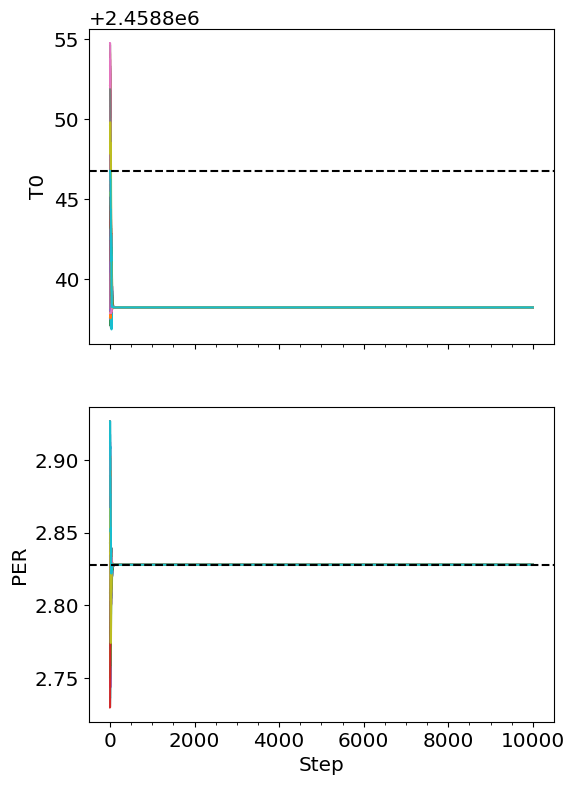

In [25]:
labels=['T0','PER']

try:
    tau = sampler.get_autocorr_time()
    print(tau)
except:
    print('Tau bad!')
    
fig, axes = plt.subplots(ndim, sharex=True, figsize=(6, 9))

for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(labels[i])
    axes[i].axhline(y=np.median(prior_slope, axis=1)[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
#plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/trace_linearfit.png')
plt.show()

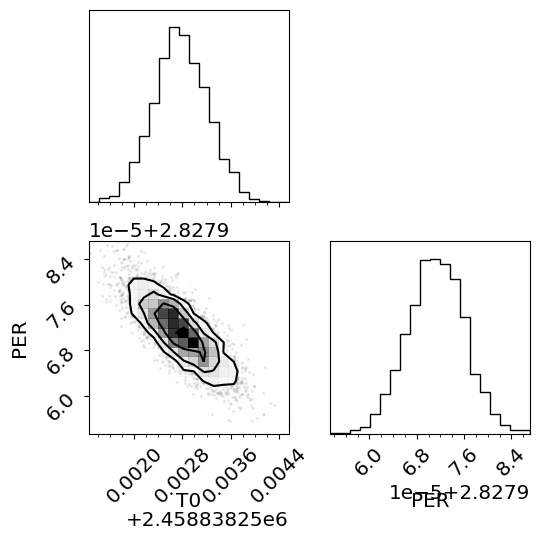

In [26]:
flat_samples = sampler.get_chain(discard=2_000, thin=100, flat=True)
fig = corner.corner(flat_samples, labels=labels)
plt.tight_layout()
#plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/corner_linearfit.png')

In [27]:
params_median = []
for i in range(ndim):
    params_median.append(np.median(flat_samples[:, i]))
params_median = np.array(params_median)

x_model = np.linspace(epochs.min(), epochs.max(), 1_000)
y_model = straight_line(x_model, *params_median)

In [251]:
# print(np.median(flat_samples.T[0]), r'+-', np.max(np.diff(np.percentile(flat_samples.T[0], [16, 50, 84]))))
# print(np.median(flat_samples.T[1]), r'+-', np.max(np.diff(np.percentile(flat_samples.T[1], [16, 50, 84]))))

2458493.2405769257 +- 0.000311464536935091
2.8279693763946216 +- 8.864520495421857e-07


In [28]:
print(np.median(flat_samples.T[0]), r'+-', np.max(np.diff(np.percentile(flat_samples.T[0], [16, 50, 84]))))
print(np.median(flat_samples.T[1]), r'+-', np.max(np.diff(np.percentile(flat_samples.T[1], [16, 50, 84]))))

2458838.252755112 +- 0.00045996764674782753
2.827971290053015 +- 4.7736141155496625e-06


In [37]:
# P_p1               	 	 2.8278688038 	 	 0.0000684877 	 	 0.0000682560
# t0_p1              	 	 2458493.2407879801 	 	 0.0003266269 	 	 0.0003344226

In [29]:
#TESS
# OC = np.zeros(NTESS.size)
# OC_lerr = np.zeros(NTESS.size)
# OC_uerr = np.zeros(NTESS.size)
#NGTS
OC = np.zeros(NNGTS.size)
OC_lerr = np.zeros(NNGTS.size)
OC_uerr = np.zeros(NNGTS.size)
count=0
for file in files:
    if file.split('.')[-1] == 'txt':
        if file != 'plots':
            temp = np.loadtxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/{file}')            
            obs = temp.T[0]
            computed = flat_samples.T[0] + int(file.split('_')[1])*flat_samples.T[1]
            #straight_line(int(file.split('_')[1]), *flat_samples.T)
            OC[count] =  np.median(obs - computed); OC_lerr[count] = np.diff(np.percentile(obs - computed, [16, 50, 84]))[0]
            OC_uerr[count] = np.diff(np.percentile(obs - computed, [16, 50, 84]))[1]
            count+=1

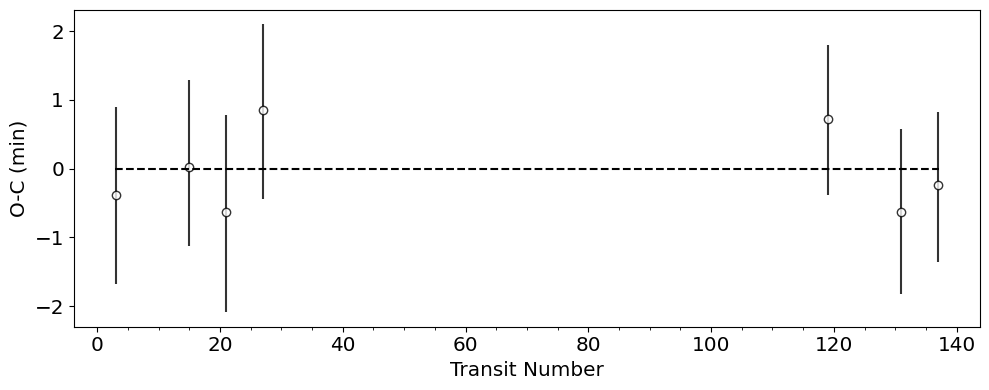

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,4))#, gridspec_kw={'width_ratios': [1,3]})
    
ax.errorbar(epochs[idxs_sort], OC[idxs_sort] * 24 * 60, yerr=np.array([OC_lerr[idxs_sort],OC_uerr[idxs_sort]])*24*60, fmt='ko',
           alpha=0.8,mfc='white', zorder=1)
ax.plot([epochs[idxs_sort].min()-0.1,epochs[idxs_sort].max()+0.1], [0,0], 'k--')
ax.set_xlabel('Transit Number')
ax.set_ylabel('O-C (min)')

plt.tight_layout()

#plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/OC.png')
# plt.close('all')

# np.savetxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/OC.txt',
#            np.c_[epochs[idxs_sort], OC[idxs_sort] * 24 * 60, OC_lerr[idxs_sort]*24*60, OC_uerr[idxs_sort]*24*60],
#            header='TransiNumber    OC[hr]    OC_1sig-lerr    OC_1sig-uerr', delimiter = '\t', fmt='%s')

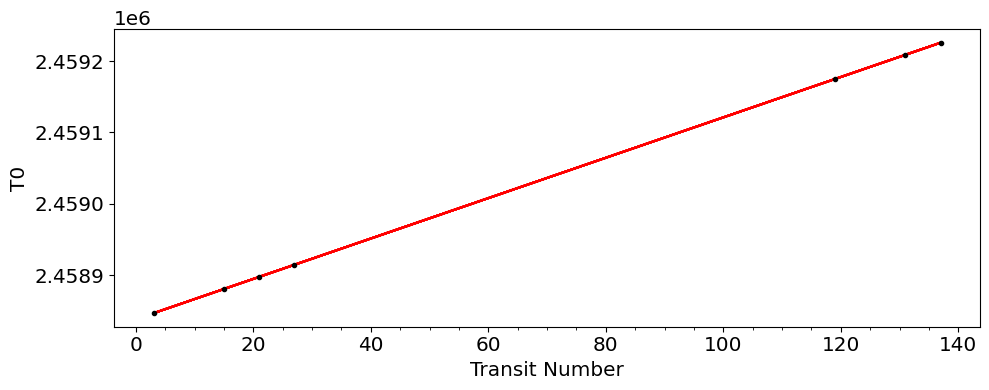

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,4), gridspec_kw={'width_ratios': [1]})

ax.errorbar(epochs, t0_median, yerr=t0_err, fmt='k.')
ax.plot(x_model, y_model, 'r--')

ax.set_xlabel('Transit Number')
ax.set_ylabel('T0')
for i in np.random.randint(0,flat_samples.shape[0], size=50):
    ax.plot(x_model, straight_line(x_model, *flat_samples[i]), 'r-', alpha=0.2)
    
# ax2.errorbar(epochs, (t0_median-straight_line(epochs, *flat_samples[i])) * 24 * 60, t0_err*24*60, fmt='ko')
# ax2.set_xlabel('Transit Number')
# ax2.set_ylabel('O-C (min)')

plt.tight_layout()

#plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/linear_fit.png')
# plt.close('all')

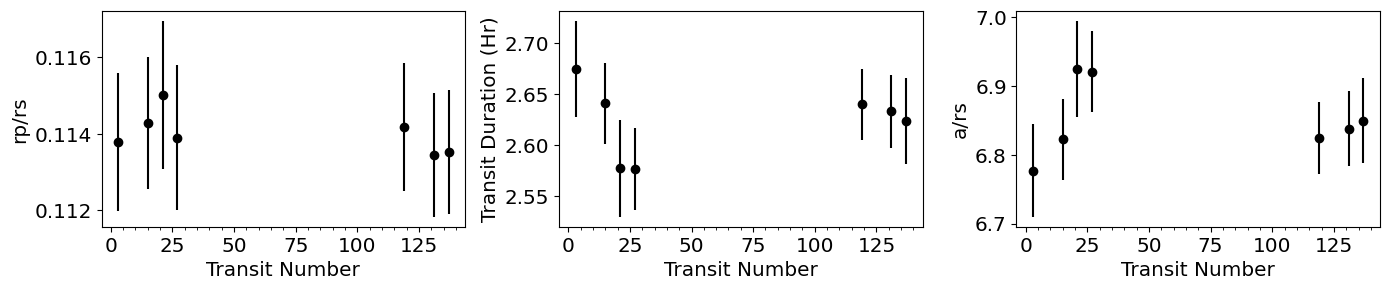

In [32]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,3), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1,1,1]})

ax.errorbar(epochs[idxs_sort], np.array(rp_median)[idxs_sort], yerr=np.array(rp_err)[idxs_sort], fmt='ko')

ax.set_xlabel('Transit Number')
ax.set_ylabel('rp/rs')
    
ax2.errorbar(epochs, np.array(tdur_median)[idxs_sort] * 24, np.array(tdur_err)[idxs_sort] * 24, fmt='ko')
ax2.set_xlabel('Transit Number')
ax2.set_ylabel('Transit Duration (Hr)')

ax3.errorbar(epochs, np.array(a_median)[idxs_sort], yerr=np.array(a_err)[idxs_sort], fmt='ko')

ax3.set_xlabel('Transit Number')
ax3.set_ylabel('a/rs')

plt.tight_layout()

# plt.savefig(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/rp-tdur-a.png')
# # plt.close('all')

# np.savetxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{folder}/plots/rp-tdur-a.txt',
#            np.c_[epochs[idxs_sort], np.array(rp_median)[idxs_sort],np.array(rp_err)[idxs_sort],
#                  np.array(tdur_median)[idxs_sort] * 24, np.array(tdur_err)[idxs_sort] * 24,
#                 np.array(a_median)[idxs_sort], np.array(a_err)[idxs_sort]],
#            header='TransiNumber    rp    rp_1sigerr Tdur[hr] Tdur_err[hr] a a_err', delimiter = '\t', fmt='%s')

## TTV Paper plot

In [33]:
# folders_ttvs = ['tess-sec04-withJitter', 'tess-sec33-withJitter', 'tess-sec34-withJitter', 'qlp-sec61-withJitter']
folders_ttvs = ['juliet-detrent-alldata-withJitter', 'ngts_full']
# folders_ttvs = ['tess-sec04-withJitter-GProtation', 'tess-sec33-withJitter-GProtation', 'tess-sec34-withJitter-GProtation', 'qlp-sec61-withJitter-GProtation']

# folders_ttvs_ngts = ['ngts']

In [34]:
N = np.array([0, 1, 2, 3, 5, 6, 7, 8,
             251, 252, 253, 254, 256, 257, 258, 259,
             261, 262, 263, 264, 265, 266, 267, 268, 269,
             520, 521, 523, 524, 525, 526, 527, 528])

# NNGTS = np.array([  3,   4,   8,  10,  14,  15,  21,  27, 101, 107, 113, 119, 120,
#        125, 126, 131, 136, 137, 142, 143, 148, 154, 155, 161, 179])
NNGTS = np.array([  3,  15,  21,  27, 119, 131, 137]) #np.copy(epochs)

#TESS
sec4_filter = N <= 8
sec33_34_filter = (N > 8) & (N <= 269)
sec61_filter = N > 269

#NGTS epochs[idxs_sort], OC[idxs_sort]
firstParts_filter = NNGTS <= 30
lastParts_filter = NNGTS > 30


# from juliet 10k livepoints
per, t0 = 2.827971, 2459986.408516 
per_err, t0_err = 0.00000153, 0.00042659
epochs = (t0 -N*per)[::-1] # t0 is the last transit
epochs_NGTS = (T0_first_NGTS +NNGTS*per)#[::-1]

OC = []
OC_errs = []
rps = []
rps_errs = []
tdurs = []
tdurs_errs = []

OC_NGTS = []
OC_errs_NGTS = []
# grab OC data
for i in folders_ttvs:
    if i != 'ngts_full':
        temp = np.loadtxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{i}/plots/OC.txt').T
        OC.append(temp[1])
        OC_errs.append([temp[2], temp[3]])
        temp2 = np.loadtxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{i}/plots/rp-tdur-a.txt').T
        rps.append(temp2[1])
        rps_errs.append(temp2[2])
        tdurs.append(temp2[3])
        tdurs_errs.append(temp2[4])
    
    if i == 'ngts_full':
        temp = np.loadtxt(f'/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/{i}/plots/OC.txt').T
        OC_NGTS.append(temp[1])
        OC_errs_NGTS.append([temp[2], temp[3]])
    
OC = np.concatenate(OC)
OC_errs = np.concatenate(OC_errs, axis=1).T

rps = np.concatenate(rps)
rps_errs = np.concatenate(rps_errs).T

tdurs = np.concatenate(tdurs)
tdurs_errs = np.concatenate(tdurs_errs).T

OC_NGTS = np.concatenate(OC_NGTS)[idxs_sort]
OC_errs_NGTS = np.concatenate(OC_errs_NGTS, axis=1).T[idxs_sort]

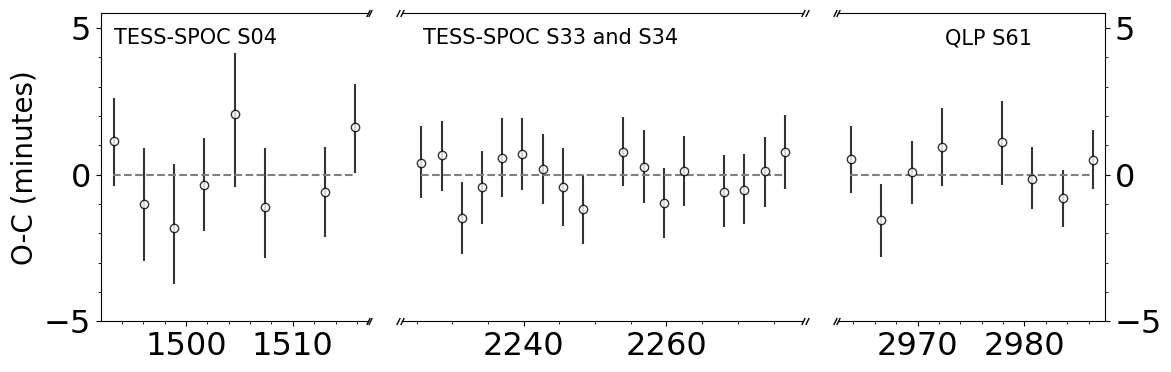

In [70]:
fig, (ax,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1.5,1]}, figsize=(12,4))

ax.errorbar(epochs[sec4_filter]-2457000, OC[sec4_filter], yerr=OC_errs[sec4_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax.plot([(epochs[sec4_filter]-2457000).min()-0.1, (epochs[sec4_filter]-2457000).max()-0.1], [0,0], color='gray', linestyle='dashed')

ax2.errorbar(epochs[sec33_34_filter]-2457000, OC[sec33_34_filter], yerr=OC_errs[sec33_34_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax2.plot([(epochs[sec33_34_filter]-2457000).min()-0.1, (epochs[sec33_34_filter]-2457000).max()-0.1], [0,0], color='gray', linestyle='dashed')

ax3.errorbar(epochs[sec61_filter]-2457000, OC[sec61_filter], yerr=OC_errs[sec61_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax3.plot([(epochs[sec61_filter]-2457000).min()-0.1, (epochs[sec61_filter]-2457000).max()-0.1], [0,0], color='gray', linestyle='dashed')

ax.sharey(ax2)
ax2.sharey(ax3)

# #NGTS
# ax.errorbar(epochs_NGTS[firstParts_filter]-2457000, OC[idxs_sort][firstParts_filter], yerr=OC_errs[idxs_sort][firstParts_filter].T, fmt='bo', alpha=0.8,mfc='white')
# ax2.errorbar(epochs_NGTS[lastParts_filter]-2457000, OC[idxs_sort][lastParts_filter], yerr=OC_errs[idxs_sort][lastParts_filter].T, fmt='bo', alpha=0.8,mfc='white')


fig.subplots_adjust(wspace=0.01)  # adjust space between axes



# ax.set_xlim(np.array([epochs.min()-5, 2458400+5])-2457000)
# ax2.set_xlim(np.array([2459020-5, t0sTESS.max()+5])-2457000)
# ax2.set_xticks(np.arange(2459020-2457000-5, t0sTESS.max()-2457000+5,20))

ax.set_ylim(-5.0, 5.5) 
ax2.set_ylim(-5.0, 5.5) 

ax.minorticks_on()
# ax.spines.right.set_visible(False)
# ax2.minorticks_on()
# ax2.spines.left.set_visible(False)
# ax2.spines.right.set_visible(False)
# ax2.axes.get_yaxis().set_visible(False)
# ax3.minorticks_on()
# ax3.spines.left.set_visible(False)
# ax3.axes.get_yaxis().set_visible(True)
# ax3.yaxis.tick_right()

ax.spines['right'].set_visible(False)
ax2.minorticks_on()
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.minorticks_on()
ax3.spines['left'].set_visible(False)
ax3.axes.get_yaxis().set_visible(True)
ax3.yaxis.tick_right()

ax.annotate(r'TESS-SPOC S04', xy=(0.05,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax2.annotate(r'TESS-SPOC S33 and S34', xy=(0.05,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax3.annotate(r'QLP S61', xy=(0.4,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')


d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([1, 1], [1, 0], transform=ax.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax.transAxes, **kwargs)

ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax2.transAxes, **kwargs)

ax3.plot([0, 0], [0, 1], transform=ax3.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax3.transAxes, **kwargs)



ax.minorticks_on()
ax.set_ylabel('O-C (minutes)', fontsize=20)
#ax2.set_xlabel(r'T$_{\rm c}$-2457000 (BJD$_{\rm TDB}$)', fontsize=25)
plt.rcParams.update({'font.size': 16})

plt.tight_layout()

plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/paperplot/ttv-detrended_paperplot_noxlab.pdf')
plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/paperplot/ttv-detrended_paperplot_noxlab.png')

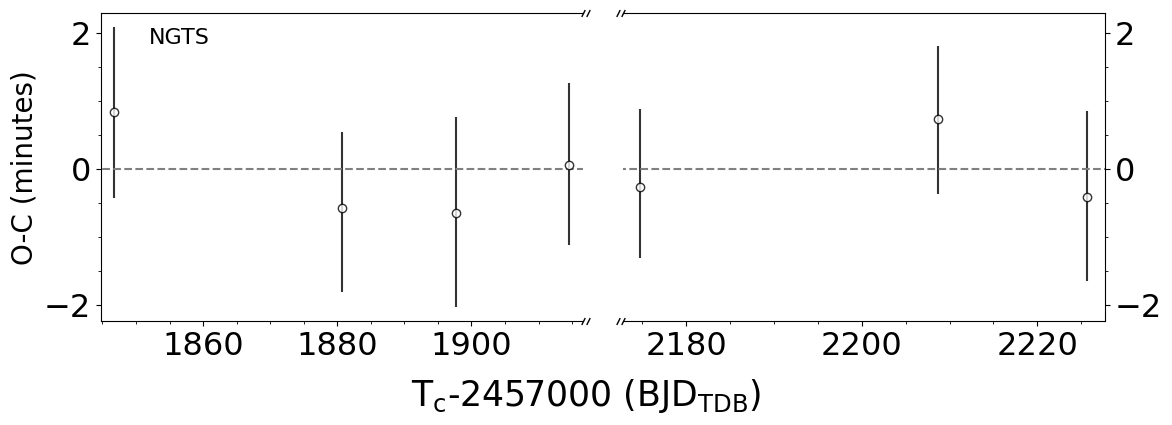

In [68]:
fig, (ax,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios':[1,1]}, figsize=(12,4))

ax.sharey(ax2)

#NGTS
ax.errorbar(epochs_NGTS[firstParts_filter]-2457000, OC_NGTS[firstParts_filter], yerr=OC_errs_NGTS[firstParts_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax.plot([(epochs_NGTS[firstParts_filter]-2457000).min()-10, (epochs_NGTS[firstParts_filter]-2457000).max()+10], [0,0], color='gray', linestyle='dashed')

ax2.errorbar(epochs_NGTS[lastParts_filter]-2457000, OC_NGTS[lastParts_filter], yerr=OC_errs_NGTS[lastParts_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax2.plot([(epochs_NGTS[lastParts_filter]-2457000).min()-10, (epochs_NGTS[lastParts_filter]-2457000).max()+10], [0,0], color='gray', linestyle='dashed')


fig.subplots_adjust(wspace=0.1)  # adjust space between axes

ax.set_xlim((epochs_NGTS[firstParts_filter]-2457000).min()-2, (epochs_NGTS[firstParts_filter]-2457000).max()+2) 
ax2.set_xlim((epochs_NGTS[lastParts_filter]-2457000).min()-2, (epochs_NGTS[lastParts_filter]-2457000).max()+2) 

# ax.set_ylim(-5.0, 5.5) 
# ax2.set_ylim(-5.0, 5.5) 

ax.minorticks_on()
ax.spines['right'].set_visible(False)
# ax_.axes.get_yaxis().set_visible(False)

ax2.minorticks_on()
ax2.spines['left'].set_visible(False)
ax2.axes.get_yaxis().set_visible(True)
ax2.yaxis.tick_right()

ax.annotate(r'NGTS', xy=(0.1,0.90),xycoords='axes fraction', fontsize=16, alpha= 1, color='black')


d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([1, 1], [1, 0], transform=ax.transAxes, **kwargs)
ax.plot([1.01, 1.01], [0, 1], transform=ax.transAxes, **kwargs)

ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax2.transAxes, **kwargs)



ax.minorticks_on()
ax.set_ylabel('O-C (minutes)', fontsize=20)
# fig.xlabel(r'T$_{\rm c}$-2457000 (BJD$_{\rm TDB}$)', fontsize=25)
fig.text(0.5, -0.05, r'T$_{\rm c}$-2457000 (BJD$_{\rm TDB}$)', ha='center', fontsize=25)
plt.rcParams.update({'font.size': 16})

plt.tight_layout()

plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/paperplot/ttv-JulietDetrended_paperplotNGTSylim.pdf',bbox_inches="tight")
plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/paperplot/ttv-JulietDetrended_paperplotNGTSylim.png',bbox_inches="tight")

In [266]:
Tdur = pfunc.transit_dur(per=2.827976, rp=0.114519, a=6.864269, inc=83.692145)
Tdur_e = pfunc.transit_dur(per=2.827976, rp=0.117123, a=7.215410, inc=84.364611) - Tdur

In [267]:
#Emperor values
rp = 0.114519
rpe = 0.0006

<IPython.core.display.Javascript object>


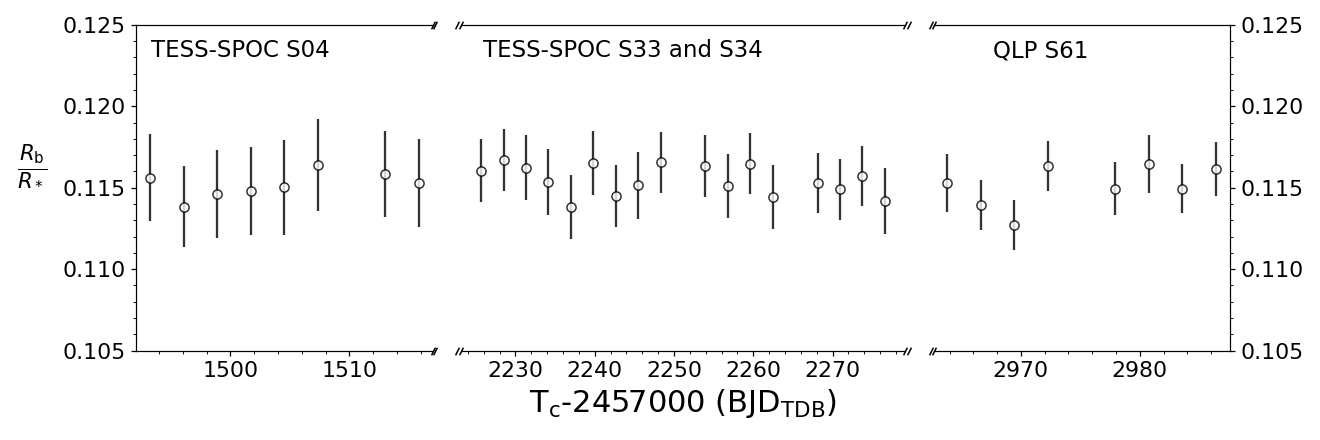

In [271]:
x_fill = np.linspace((epochs[sec4_filter]-2457000).min()-0.1,(epochs[sec4_filter]-2457000).max()-0.1, 100)
x_fill2 = np.linspace((epochs[sec33_34_filter]-2457000).min()-0.1,(epochs[sec33_34_filter]-2457000).max()-0.1, 100)
x_fill3 = np.linspace((epochs[sec61_filter]-2457000).min()-0.1,(epochs[sec61_filter]-2457000).max()-0.1, 100)

fig, (ax,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1.5,1]}, figsize=(12,4))

ax.errorbar(epochs[sec4_filter]-2457000, rps[sec4_filter], yerr=rps_errs[sec4_filter].T, fmt='ko', alpha=0.8,mfc='white')
# ax.plot([(epochs[sec4_filter]-2457000).min()-0.1, (epochs[sec4_filter]-2457000).max()-0.1], [rp,rp], color='gray', linestyle='solid')
# ax.fill_between(x_fill, np.ones(100)*(rp-rpe),np.ones(100)*(rp+rpe), color='gray', linestyle='solid', alpha=0.2)

ax2.errorbar(epochs[sec33_34_filter]-2457000, rps[sec33_34_filter], yerr=rps_errs[sec33_34_filter].T, fmt='ko', alpha=0.8,mfc='white')
# ax2.plot([(epochs[sec33_34_filter]-2457000).min()-0.1, (epochs[sec33_34_filter]-2457000).max()-0.1], [rp,rp], color='gray', linestyle='solid')
# ax2.fill_between(x_fill2, np.ones(100)*(rp-rpe),np.ones(100)*(rp+rpe), color='gray', linestyle='solid', alpha=0.2)

ax3.errorbar(epochs[sec61_filter]-2457000, rps[sec61_filter], yerr=rps_errs[sec61_filter].T, fmt='ko', alpha=0.8,mfc='white')
# ax3.plot([(epochs[sec61_filter]-2457000).min()-0.1, (epochs[sec61_filter]-2457000).max()-0.1], [rp,rp], color='gray', linestyle='solid')
# ax3.fill_between(x_fill3, np.ones(100)*(rp-rpe),np.ones(100)*(rp+rpe), color='gray', linestyle='solid', alpha=0.2)

ax.sharey(ax2)
ax2.sharey(ax3)

ax.set_ylim(0.105, 0.125)

fig.subplots_adjust(wspace=0.01)  # adjust space between axes

ax.minorticks_on()
ax.spines.right.set_visible(False)
ax2.minorticks_on()
ax2.spines.left.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.minorticks_on()
ax3.spines.left.set_visible(False)
ax3.axes.get_yaxis().set_visible(True)
ax3.yaxis.tick_right()

ax.annotate(r'TESS-SPOC S04', xy=(0.05,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax2.annotate(r'TESS-SPOC S33 and S34', xy=(0.05,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax3.annotate(r'QLP S61', xy=(0.2,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([1, 1], [1, 0], transform=ax.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax.transAxes, **kwargs)

ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax2.transAxes, **kwargs)

ax3.plot([0, 0], [0, 1], transform=ax3.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax3.transAxes, **kwargs)



ax.minorticks_on()
ax.set_ylabel(r'$\frac{R_{\rm b}}{R_*}$', fontsize=20, rotation=0, labelpad=20)
# ax.yticks(rotation=90)

ax2.set_xlabel(r'T$_{\rm c}$-2457000 (BJD$_{\rm TDB}$)', fontsize=20)
plt.tight_layout()

# plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/rp-GProtation-detrended_paperplot.pdf')
# plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/rp-GProtation-detrended_paperplot.png')

<IPython.core.display.Javascript object>


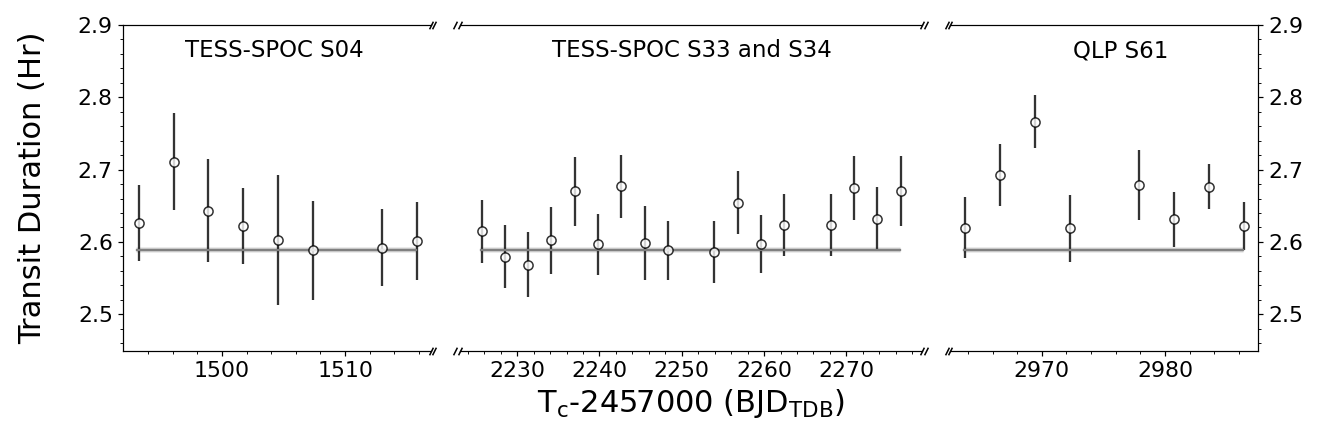

In [269]:
x_fill = np.linspace((epochs[sec4_filter]-2457000).min()-0.1,(epochs[sec4_filter]-2457000).max()-0.1, 100)
x_fill2 = np.linspace((epochs[sec33_34_filter]-2457000).min()-0.1,(epochs[sec33_34_filter]-2457000).max()-0.1, 100)
x_fill3 = np.linspace((epochs[sec61_filter]-2457000).min()-0.1,(epochs[sec61_filter]-2457000).max()-0.1, 100)

fig, (ax,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1.5,1]}, figsize=(12,4))

ax.errorbar(epochs[sec4_filter]-2457000, tdurs[sec4_filter], yerr=tdurs_errs[sec4_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax.plot([(epochs[sec4_filter]-2457000).min()-0.1, (epochs[sec4_filter]-2457000).max()-0.1], [Tdur*24,Tdur*24], color='gray', linestyle='solid')
ax.fill_between(x_fill, np.ones(100)*(Tdur-Tdur_e)*24,np.ones(100)*(Tdur+Tdur_e)*24, color='gray', linestyle='solid', alpha=0.2)

ax2.errorbar(epochs[sec33_34_filter]-2457000, tdurs[sec33_34_filter], yerr=tdurs_errs[sec33_34_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax2.plot([(epochs[sec33_34_filter]-2457000).min()-0.1, (epochs[sec33_34_filter]-2457000).max()-0.1], [Tdur*24,Tdur*24], color='gray', linestyle='solid')
ax2.fill_between(x_fill2, np.ones(100)*(Tdur-Tdur_e)*24,np.ones(100)*(Tdur+Tdur_e)*24, color='gray', linestyle='solid', alpha=0.2)

ax3.errorbar(epochs[sec61_filter]-2457000, tdurs[sec61_filter], yerr=tdurs_errs[sec61_filter].T, fmt='ko', alpha=0.8,mfc='white')
ax3.plot([(epochs[sec61_filter]-2457000).min()-0.1, (epochs[sec61_filter]-2457000).max()-0.1], [Tdur*24,Tdur*24], color='gray', linestyle='solid')
ax3.fill_between(x_fill3, np.ones(100)*(Tdur-Tdur_e)*24,np.ones(100)*(Tdur+Tdur_e)*24, color='gray', linestyle='solid', alpha=0.2)

ax.sharey(ax2)
ax2.sharey(ax3)

ax.set_ylim(2.45, 2.9)


fig.subplots_adjust(wspace=0.01)  # adjust space between axes

ax.minorticks_on()
ax.spines.right.set_visible(False)
ax2.minorticks_on()
ax2.spines.left.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.minorticks_on()
ax3.spines.left.set_visible(False)
ax3.axes.get_yaxis().set_visible(True)
ax3.yaxis.tick_right()

ax.annotate(r'TESS-SPOC S04', xy=(0.2,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax2.annotate(r'TESS-SPOC S33 and S34', xy=(0.2,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')
ax3.annotate(r'QLP S61', xy=(0.4,0.90),xycoords='axes fraction', fontsize=15, alpha= 1, color='black')

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([1, 1], [1, 0], transform=ax.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax.transAxes, **kwargs)

ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([1.01, 1.01], [1, 0], transform=ax2.transAxes, **kwargs)

ax3.plot([0, 0], [0, 1], transform=ax3.transAxes, **kwargs)
ax2.plot([-0.01, -0.01], [0, 1], transform=ax3.transAxes, **kwargs)



ax.minorticks_on()
ax.set_ylabel(r'Transit Duration (Hr)', fontsize=20, rotation=90, labelpad=20)
# ax.yticks(rotation=90)

ax2.set_xlabel(r'T$_{\rm c}$-2457000 (BJD$_{\rm TDB}$)', fontsize=20)
plt.tight_layout()

# plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/tdur-GProtation-detrended_paperplot.pdf')
# plt.savefig('/home/astropc/Universidade/UniversidadChile/research/NOI-106557/ttvs/tdur-GProtation-detrended_paperplot.png')

## Compare with Juliet Results

In [ ]:
import juliet
target = 'NOI-105592'
folder = '/home/astropc/Universidade/UniversidadChile/research/NOI-106557/juliet_runs/run2_tess-qlp61_tightPriors_livepoints10k/'#f'/data2/dalves/toi193_transitGP_TTVs/TTVs/'
folder_save_files = folder + 'ttvs/run2_r1r2_uniform'
# Create dictionaries:
times, fluxes, fluxes_error = {},{},{}
inst='TESS'
for inst in ['TESS']:
    t, f, ferr = np.loadtxt(f'{folder}/{inst}_GPmodeled.txt', delimiter=',').T
    cond = ~np.isnan(f)
    t,f,ferr = t[cond], f[cond], ferr[cond]

    # Save data into those dictionaries:
    times[f'{inst}'], fluxes[f'{inst}'], fluxes_error[f'{inst}'] = t,f,ferr
    

dataset = juliet.load(priors=folder_save_files+'/priors.dat', t_lc = times, y_lc = fluxes, yerr_lc = fluxes_error, out_folder = folder_save_files, verbose=True)


results = dataset.fit(sampler='dynamic_dynesty', n_live_points=39 ** 2 + 500, nthreads=8,  pl=0, pu=1.)

In [ ]:
#Making the OC data
trans_num = NTESS#np.array([0, 1] + list(np.arange(4,18)) + list(np.arange(463,468)) + list(np.arange(469, 477)))
OC = np.zeros(len(trans_num))
OC_up_err = np.zeros(len(OC))
OC_down_err = np.zeros(len(OC))
for i, transit_number in enumerate(trans_num):
    # Now go through known transit-numberings, and generate the O-C distributions. From there,
    # compute the medians and 68% credibility bands:
        #Compute distribution of predicted times:
        computed_time = results.posteriors['posterior_samples']['t0_p1'] + transit_number*results.posteriors['posterior_samples']['P_p1']
        #Extract observed times:
        observed_time = results.posteriors['posterior_samples']['T_p1_'+'TESS'+'_'+str(transit_number)]
        #Generate O-C (multiply by 24*60 to get it in minutes) posterior distribution,
        #and get quantiles from it:
        val,vup,vdown = juliet.utils.get_quantiles((observed_time - computed_time)*24*60.)
        #Save value and "1-sigma" errors:
        OC[i], OC_up_err[i], OC_down_err[i] = val, vup-val,val-vdown

#median of sectors
cond = trans_num < 100
median_trans_num = np.array([np.median(trans_num[cond]),np.median(trans_num[~cond])])
ivars = (1/np.max(np.array([OC_down_err,OC_up_err]).T, axis=1))**2 #get max between lower_upper errors as ivar
#ivar weighterd
median_ttv = np.array([np.sum(OC[cond] * ivars[cond])/np.sum(ivars[cond]),np.sum(OC[~cond] * ivars[~cond])/np.sum(ivars[~cond])])
median_ttv_err = np.array([np.std(OC[cond])/(np.sum(OC[cond].size)**.5), np.std(OC[~cond])/(np.sum(OC[~cond].size)**.5)])
#simple median
median_ttv_median = np.array([np.median(OC[cond]), np.median(OC[~cond][:-1])])
median_ttv_err_stm = np.array([np.std(OC[cond])/(np.sum(OC[cond].size)**.5), np.std(OC[~cond][:-1])/(np.sum(OC[~cond][:-1].size)**.5)])

#Plotting
fig = plt.figure(figsize=(14,4))
plt.errorbar(trans_num,OC,yerr=[OC_down_err,OC_up_err],fmt= 'ko', alpha=.1, label= 'TESS')
plt.errorbar(trans_num,OC,yerr=[OC_down_err,OC_up_err],fmt= 'ko', alpha=.1)
plt.errorbar(median_trans_num, median_ttv, median_ttv_err, fmt= 'ro', alpha=.8, ms=7., label= f'Sector ivar weighted offset {np.diff(median_ttv)[0]:.4f} min')
plt.errorbar(median_trans_num, median_ttv_median, median_ttv_err_stm, fmt= 'go', alpha=.8, ms=5., label= f'Sector simple median (outlier removed) offset {np.diff(median_ttv_median)[0]:.4f} min')

    
plt.plot([trans_num.min(), trans_num.max()],[0.,0],'--',linewidth=1,color='black',zorder=2)
plt.legend(fontsize='small')
plt.xlabel('Transit number')
plt.ylabel('O-C (minutes)')

In [ ]:
epochs

In [ ]:
fig, ax = plt.subplots(1,1)

ax.hist(obs, bins=50, alpha=0.5)
ax.hist(computed, bins=50, alpha=0.5)

ax.hist(results.posteriors['posterior_samples']['T_p1_'+'TESS'+'_'+str(5)], bins=50, alpha=0.5)
ax.hist(results.posteriors['posterior_samples']['t0_p1'] + 5*results.posteriors['posterior_samples']['P_p1'], bins=50, alpha=0.5)

# Model T0 one by one

In [ ]:
priors = np.array([linear_ephTESS[np.where(NTESS == 523)[0][0]]-0.05,linear_ephTESS[np.where(NTESS == 523)[0][0]]+0.05,
      rp-0.05,rp+0.05,
      a-0.5,a+0.5,
      0.0-1e-3, 0.0+1e-3]).reshape(4,2)

In [ ]:
detr_data = np.array([tess_data[0],
                      tess_data[1] - model_50q_full + 1,
                      tess_data[-1]
                     ])
transit_mask = (detr_data[0] > linear_ephTESS[np.where(NTESS == 523)[0][0]] - offset) & (detr_data[0] < linear_ephTESS[np.where(NTESS == 523)[0][0]] + offset)

In [ ]:
ndim = priors.shape[0]
nwalkers = 100#ndim*2  # Number of walkers. It is recommended to be at least higher than twice 
                   # the amount of parameters being fit


# theta = [t0, rp, a, baseline ]
# Guess gaussian ball
# order_of_mag = np.array([1e-3, 1e-4, 0.05, 1e-6])
# pos = np.median(priors, axis=1) + order_of_mag * np.random.randn(nwalkers, ndim)
# Starting Uniform ball around guess value
pos = np.zeros((ndim, nwalkers))
for n, (c,d) in enumerate(priors):
    pos[n] = (d - c) * np.random.random_sample(nwalkers) + c

pos = pos.T
# If you want to use parallelization
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(detr_data[0][transit_mask], detr_data[1][transit_mask], detr_data[2][transit_mask]),pool=pool)
    # This line below will fit the entire data set, incl OOT. Time consuming.
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error),pool=pool)
    sampler.run_mcmc(pos, 10_000, progress=True)
    
# If you *do not* want to use parallelization
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_error))
# sampler.run_mcmc(pos, 1000, progress=True);

In [ ]:
labels=['t0','rp','a','baseline']

try:
    tau = sampler.get_autocorr_time()
    print(tau)
except:
    print('Tau bad!')
    
fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, 12.0))

for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(labels[i])
    axes[i].axhline(y=np.median(priors, axis=1)[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
plt.show() 

In [ ]:
# q_low, q_up = np.percentile(flat_samples.T[2], [0.2, 99.8])
# t0_dist = (flat_samples.T[2] > q_low) & (flat_samples.T[2] < q_up)
# fig, ax = plt.subplots(1,1)

# ax.hist(flat_samples.T[2])
# ax.hist(flat_samples.T[2][t0_dist])

In [ ]:
flat_samples = sampler.get_chain(discard=2_000, thin=200, flat=True)


# fit = np.array([])

# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))
#     fit = np.append(fit, [mcmc[1]])
    
fig = corner.corner(flat_samples, labels=labels)

In [ ]:
params_median = []
for i in range(ndim):
    params_median.append(np.median(flat_samples[:, i]))
params_median = np.array(params_median)

x_model = np.linspace(detr_data[0][transit_mask].min(), detr_data[0][transit_mask].max(), 1_000)
y_model = f_batman(x_model, *params_median)


In [ ]:
fig, ax = plt.subplots(1,1)

ax.errorbar(detr_data.T[transit_mask].T[0] - params_median[0], *detr_data.T[transit_mask].T[1:], fmt='.')
ax.plot(x_model- params_median[0], y_model, 'r--')

ax.set_xlabel('Time - T0')
ax.set_ylabel('Norm. Flux')
for i in np.random.randint(0,flat_samples.shape[0], size=50):
    ax.plot(x_model- params_median[0], f_batman(x_model, *flat_samples[i]), 'r-', alpha=0.2)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.hist(flat_samples.T[0], bins=50)

## Run TTV + TDV + Depth variation with batman + emcee

# Run linear fit with emcee 

In [ ]:
# Mask transits 

In [ ]:
# Run GP 
#tmin = oot_tess_data[0].min()
#mu = np.mean(oot_tess_data[1])

time = oot_tess_data[0]# - tmin
flux = oot_tess_data[1]#(oot_tess_data[1]/mu -1)*1e3
flux_err = oot_tess_data[2] #* 1e3 / mu

mask_vals = [] # Save timestamps that is clipped
run_mcmc = True
for _ in range(100):
    # Run GP
    model, gp, map_soln, t_model = run_GP(*oot_tess_data)#time, flux, flux_err)#, per=per)

    #compute sigma clipping on residuals
    mask_nans_gp = np.isnan(map_soln["pred"])
    if len(time[~mask_nans_gp]) > 0:

        time, res_flux, flux_err, mask_ids, original_data = pfunc.sigma_clipping(time[~mask_nans_gp], (flux - map_soln["pred"])[~mask_nans_gp], flux_err[~mask_nans_gp], nsig=3, niter=10, mask_id=True) #data is overwritten with clipped data

        if len(mask_ids) > 0:
            flux = np.delete(flux, mask_ids)
            mask_vals.append(data[0][mask_ids]) # removed timestamps
        else:
            break

        print(f'# iterations GP sigma clipping: {len(mask_vals)}')
        idx_masked_fluxes = np.array([np.where(i==data[0])[0][0] for i in np.concatenate(mask_vals)])
    else:
        run_mcmc = False
        print('GP prediction map_soln has only nan values')
        break
if run_mcmc:

    with model:

        trace = pmx.sample(
            tune=2000,
            draws=2000,
            start=map_soln,
            cores=14,
            chains=4,
            target_accept=0.9,
            return_inferencedata=True
        )

    gp_period = np.diff(np.percentile(np.asarray(trace.posterior["period"]).flatten(), [16,50, 84]))
    #amp = compute_amp(); amp_quantiles = np.percentile(amp, [16, 50, 84])
    gp_mu = np.median(trace.posterior['pred_t_model'][:, :, :], axis=[0,1])
    gp_1sig = np.percentile(trace.posterior['pred_t_model'][:, :, :],[16,84], axis=[0,1])
    folded = t_model/gp_period[1] %1

#     amp = np.diff(np.percentile(gp_mu[np.argsort(folded)], [1,99]))[0]/2
#             amp_l = amp - np.percentile(gp_1sig[0][np.argsort(folded)],[99])[0] # diff between median_amp and model at 84 perc median
#             amp_u = np.percentile(gp_1sig[1][np.argsort(folded)],[99])[0] - amp
#     np.savetxt(save_plots+'/GP/' + f'star_{star}_prot.txt',[star, gp_period[0], *np.diff(gp_period), amp],
#                fmt='%s', header='star_id gp_per[days] gp_perr_1sigl gp_perr_1sigu Amp[ppt]')
#                 np.savetxt(save_plots+'/GP/' + f'star_{star}_prot.txt',[star, gp_period[0], *np.diff(gp_period), amp_quantiles[1], *np.diff(amp_quantiles)],
#                            fmt='%s', header='star_id gp_per[days] gp_perr_1sigl gp_perr_1sigu Amp[ppt] Amp_1sigl Amp_1sigu')
    plot_lcs(save_plot=True)
    #planet_search()
#     plt.close('all')

In [ ]:
# Run GP 
tmin = oot_tess_data[0].min()
mu = np.mean(oot_tess_data[1])

time = oot_tess_data[0] - tmin
flux = (oot_tess_data[1]/mu -1)*1e3
flux_err = oot_tess_data[2] * 1e3 / mu

In [ ]:
model, gp, map_soln, t_model = run_GP(*oot_tess_data, tess_data[0])

In [ ]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True)

ax.errorbar(*tess_data, fmt='.')
ax.errorbar(*oot_tess_data, fmt='.')
ax.plot(tess_data[0], map_soln['pred_t_transits'], 'r--')

ax2.errorbar(tess_data[0], tess_data[1] - map_soln['pred_t_transits'] + 1, tess_data[2], fmt='.')
# ax.errorbar(oot_tess_data, fmt='.')
# ax.plot(tess_data[0], map_soln['pred_t_transits'], 'r--')


In [ ]:
#star = 82236
for _, star in enumerate(star_ids.astype(int)):
    try:
        
    
        data, total_size, masked_size = rot_data(star, binsize_timeseries=30/(60*24), norm=False)
        data_5min, _, _, _, _, _, _ = rot_data(star, binsize_timeseries=5/(60*24), norm=False)
        print(f'############## running star {star} #############')

        per = guess_periods[np.where(str(star) == star_ids)[0][0]].astype(float)
#         acf_per = cluster_ids.T[-1][np.where(str(star) == star_ids)[0][0]]
#         acf_per = acf_per.astype(float) if acf_per != 'no ACF detected' else np.nan

        tmin = data[0].min()
        mu = np.mean(data[1])

        time = data[0] - tmin
        flux = (data[1]/mu -1)*1e3
        flux_err = data[2] * 1e3 / mu

        mask_vals = [] # Save timestamps that is clipped
        for _ in range(100):
            # Run GP
            model, gp, map_soln, t_model = run_GP(time, flux, flux_err, data_5min[0] - data_5min[0].min())

            #compute sigma clipping on residuals
            mask_nans_gp = np.isnan(map_soln["pred"])
            if len(time[~mask_nans_gp]) > 0:

                time, res_flux, flux_err, mask_ids, original_data = pfunc.sigma_clipping(time[~mask_nans_gp], (flux - map_soln["pred"])[~mask_nans_gp], flux_err[~mask_nans_gp], nsig=3, niter=10, mask_id=True) #data is overwritten with clipped data

                if len(mask_ids) > 0:
                    flux = np.delete(flux, mask_ids)
                    mask_vals.append(data[0][mask_ids]) # removed timestamps
                else:
                    break

                print(f'# iterations GP sigma clipping: {len(mask_vals)}')
                idx_masked_fluxes = np.array([np.where(i==data[0])[0][0] for i in np.concatenate(mask_vals)])

                with model:

                    trace = pmx.sample(
                        tune=2000,
                        draws=2000,
                        start=map_soln,
                        cores=14,
                        chains=4,
                        target_accept=0.9,
                        return_inferencedata=True
                    )

                plot_lcs(save_plot=True)
                planet_search()
            else:
                continue
    except:
        print(f'SKIPPED STAR {star}')
        continue

# TO DO NEXT --> INJECT TRANSITS AND CHECK HOW GP REACTS WITH INV GAMMA FUNC AND NORMAL FUNCTIONS

## HOW TO GET MODEL FROM POSTERIOR DISRIBUTIONS OF PYMC3 SEE TUTORIALS??

### See how ED builds the GP and use it as close as possible

### DECIDE HOW TO PLOT IT AND
### RUN ON EVERY STAR 

In [ ]:
star = 46620
data_5min, total_size, masked_size, tic_id, Teff, Gmag, from_megafile = rot_data(star, binsize_timeseries=5/(60*24), norm=False, clip_binned_data=False, from_megafile=True)
mu = np.mean(data_5min[1])

data_5min[1] = (data_5min[1]/mu -1)*1e3
data_5min[2] = data_5min[2] * 1e3 / mu


#Inject planet
f_planet = pfunc.f_batman(data_5min[0], t0=np.median(data_5min[0]), a=5, per=0.6, rp=0.1)
data_5min[1] += (f_planet-1)*1e3

#Bin data to 30 min for rotation with planet

data = bin_data(*data_5min, step=30/(60*24), avrg='median', normalize=False)


In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(data_5min[0], data_5min[1], '.')
ax.plot(data_5min[0], (f_planet-1)*1e3, 'r--')

In [ ]:
# investigate why lc from megafile have a few huge errorbars while the files from 2bz doesnt
# The clipping + binning procedure is the same, and raw LCs from both sources are the same

#For the GP do clipping + binning + clipping on binned data or do like Ed did in the paper to identify outliers
#and remove them prior to the actual mcmc fit

In [ ]:
per = guess_periods[np.where(str(star) == star_ids)[0][0]].astype(float)
acf_per = cluster_ids.T[-1][np.where(str(star) == star_ids)[0][0]].astype(float) 
time,flux,flux_err = data
time_5min,flux_5min,flux_err_5min = data_5min







## Using rotation kernel from the exoplanet package

In [ ]:
with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=np.std(flux))

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.median(flux_err)), sigma=5.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(per), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=time,
        diag=flux_err**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux)
    
    # Compute the mean model for a the 5 min data grided
    pm.Deterministic("pred_t_model", gp.predict(flux, t = time_5min))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(data_5min[0], data_5min[1], "k.", label="data_5min", alpha=0.1)
ax.plot(time_5min, flux_5min, "b.", label="data_5min")

ax.plot(data[0], data[1], "k.", label="data", alpha=0.1)
ax.plot(time, flux, "k.", label="data")

ax.plot(time_5min, map_soln["pred_t_model"], color="C3", label="model", alpha=0.8)
# ax.legend(fontsize=10)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]")
_ = ax.set_title(f"NGTS ID {star}; map model")


new_dat = pfunc.sigma_clipping(time, flux - map_soln["pred"], flux_err, nsig=5, niter=10, mask_id=True)
new_dat_5min = pfunc.sigma_clipping(time_5min, flux_5min - map_soln["pred_t_model"], flux_err_5min, nsig=5, niter=10, mask_id=True)

if len(new_dat[3]) > 0:
    
    ax.plot(time[new_dat[3]], (flux - map_soln["pred"])[new_dat[3]], "r.", label="O-C")
    time, flux, flux_err = np.delete(time, new_dat[3]), np.delete(flux, new_dat[3]), np.delete(flux_err, new_dat[3])
    time_5min, flux_5min, flux_err_5min = np.delete(time_5min, new_dat_5min[3]), np.delete(flux_5min, new_dat_5min[3]), np.delete(flux_err_5min, new_dat_5min[3])

    
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(time_5min, flux_5min - map_soln["pred_t_model"], "b.", alpha=0.6, label="O-C")
ax.plot(time, flux - map_soln["pred"], "k.", label="O-C")
# ax.legend(fontsize=10)
ax.set_xlabel("time [days]")
ax.set_ylabel("O-C [ppt]")
ax.set_title(f"NGTS ID {star}; map model")




In [ ]:
f_search = (flux_5min - map_soln["pred_t_model"] + mu)/np.median(flux_5min - map_soln["pred_t_model"] + mu)
pfunc.run_tls(time_5min, f_search, period_min=0.3, period_max=30, path='.', name='.', use_threads=14)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(data_5min[0], data_5min[1], "k.", label="data", alpha=0.1)
ax.plot(time_5min, flux_5min, "k.", label="data")
ax.plot(data_5min[0], (f_planet-1)*1e3, 'b--')

ax.plot(time_model, map_soln["pred_t_model"], color="C3", label="model", alpha=0.8)
# ax.legend(fontsize=10)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]")
_ = ax.set_title(f"NGTS ID {star}; map model")


fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(time_5min, flux_5min - map_soln["pred_t_model"], "k.", label="O-C")
# ax.legend(fontsize=10)
ax.set_xlabel("time [days]")
ax.set_ylabel("O-C [ppt]")
ax.set_title(f"NGTS ID {star}; map model")




In [ ]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=14,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

In [ ]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
folded_t = time/np.median(period_samples) %1
sorted_t = np.argsort(folded_t)
fig, (ax,ax2) = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'width_ratios':[2,1]})
ax.scatter(folded_t, flux, c=time, cmap='rainbow', s=10, alpha=0.8, label="data")
# ax.legend(fontsize=10)
ax.set_xlabel("Phase")
ax.set_ylabel("relative flux [ppt]")


ax2.hist(period_samples, 25, histtype="step", color="red", density=True)
# ax2.axvspan(*np.percentile(period_samples, [16, 84]), color='orange')

# For label purposes
handles = []
for p,c in zip([per, acf_per], ['C0', 'C4']):
    ax2.axvspan(p-1e-6, p+1e-6, color=c, label='LS' if c=='C0' else 'ACF')
    vertical_line = lines.Line2D([], [],  marker='|', linestyle='None', color=c,
                             markersize=10, markeredgewidth=1.5)
    handles.append(vertical_line)
_, labels = ax2.get_legend_handles_labels()

ax2.set_yticks([])
ax2.set_xlabel("Rotation period [days]")
_ = ax2.set_ylabel("PDF")
ax2.legend(handles,labels)
plt.tight_layout()

In [ ]:
acf_per

In [ ]:
import corner

samples = np.vstack([*data])

figure = corner.corner(samples, labels=labels)

In [ ]:
trace.posterior[i].flatten()

In [ ]:
labels = []
data = []
for i in trace.posterior.data_vars:
    labels.append(i)
    data.append(np.asarray(trace.posterior[i]).flatten())
    

In [ ]:
# FROM ALEX
def buildmodel(x, y, dy, period_est, test_points):
    
    
    #model times, These are 'test' points
    #xm = np.r_[np.nanmin(x)-5:np.nanmax(x)+5:test_points]
    xm = np.linspace(np.nanmin(x)-5, np.nanmax(x)+5, test_points)
    
    
    #find 10th & 90th percentile flux values and create log value for data spread
    flux_1090_per = np.percentile(y, [10,90], axis = -1)
    data_spread = abs(flux_1090_per[0] - flux_1090_per[1])
    data_spread = np.log(data_spread)
    #print("log data spread is:", data_spread)  
    
    
    with pm.Model() as model:
        
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    
        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(dy)), sigma=2.0)
        
        ###### A term to describe the non-periodic variability######
        #sigma = pm.InverseGamma("sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
        #rho = pm.InverseGamma("rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
        #kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / np.sqrt(2))
        logS = pm.Normal("logS", mu=0.0, sd= np.log(data_spread), testval=np.log(np.var(y))) #S0 in numrtr of PSD (controls amp)
        logW = pm.Normal("logw", mu=np.log(2*np.pi/100), sd=10.0) # W0 undamped angular freq, denom is therefore the period
        w0 = pm.Deterministic("w0", tt.exp(logW))
        kernel = terms.SHOTerm(S0=tt.exp(logS), w0=tt.exp(logW), Q=1/np.sqrt(2))
        
        
        ####### The parameters of the RotationTerm kernel########
        #sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
        sigma_rot = pm.Normal("logamp", mu=0.0, sd=np.log(data_spread)) #standard deviation of process
        log_period = pm.Normal("log_period", mu=np.log(period_est), sigma=2) #primary period of variaibility/rotation
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.Uniform("log_Q0", lower=3.0, upper=10.0 , testval=5.0) #damping factor
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma = 5.0) 
        f = pm.Uniform("f", lower=0.1, upper=1.0 , testval = 0.5) # fractional amp of secondary mode of variability
        
        #Add RotationTerm for the stellar rotation period
        #Use LS Period at max power estimate for the primary period estimate
        kernel += terms.RotationTerm(sigma=tt.exp(sigma_rot), period=period, Q0=tt.exp(log_Q0), dQ=tt.exp(log_dQ),f=f)
        
        #Create GP
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=dy**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )
    
        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)
    
        # Compute the mean model prediction
        #This line is predicting what the model params should be at time xm, this is purely for fitting
        pm.Deterministic("pred", gp.predict(y, t = xm))
        
        #Need to draw the model flux values at the same times as our observational data so that we can
        #take the difference between the two for the residuals plot
        pm.Deterministic("pred_resid", gp.predict(y))
    
        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize()
        
    return model, gp, map_soln 

In [ ]:
def neg_log_like(params, f, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(f)

In [ ]:
# # 1st kernel
# Q1 = 1.0/np.sqrt(2)
# S0 = 1
# w0 = 1
# bounds = dict(log_S0=(-np.inf, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q1), log_omega0=np.log(w0),
#                        bounds=bounds)

# kernel.freeze_parameter("log_Q")

# # 3rd kernel
# f = 0 + 1e-5 # 0 < f < 1
# A = 1. # A > 0
# Q3 = 0.5 + 1e-5 # Q3 > 1/2 
# w3 = 8*np.pi*Q3/(per * np.sqrt(4*Q3**2 -1))
# S3 = f*A / (w3*Q3)

# bounds = dict(log_S0=(-np.inf, np.inf), log_Q=(np.log(1/2), np.inf))
# kernel += terms.SHOTerm(log_S0=np.log(S3), log_Q=np.log(Q3), log_omega0=np.log(w3),
#                        bounds=bounds)

# # 2nd kernel
# delQ = 0 + 1e-5
# Q2 = Q3 + delQ # delQ > 0 Q3 > 1/2 --> Q2 > 1/2
# w2 = 4*np.pi*Q2/(per * np.sqrt(4*Q2**2 -1))
# S2 = A / (w2*Q2) # A > 0 , Q2 > 1/2 --> S2 > 2*A/w2

# bounds = dict(log_S0=(np.log(2*A/w2), np.inf), log_Q=(np.log(1/2), np.inf))
# kernel += terms.SHOTerm(log_S0=np.log(S2), log_Q=np.log(Q2), log_omega0=np.log(w2))


# gp = celerite.GP(kernel, mean=np.nanmean(flux))
# gp.compute(time, flux_err)  # You always need to call compute once.

# # redefine initial guess based on nll
# initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

# r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(flux, gp))
# # gp.set_parameter_vector(r.x)

# # RUN GP
# t_model = np.linspace(time.min(), time.max(), int(time.size*10))
# pred_mean, pred_var = gp.predict(flux, t_model, return_var=True)
# pred_std = np.sqrt(pred_var)

In [ ]:
# If we use the autograd wrappers around numpy then the gradients
# of the term will be computed automatically.
import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(-log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            np.exp(-log_c), 2*np.pi*np.exp(-log_P),
        )

In [ ]:
np.log(2*np.std(flux))

In [ ]:
np.exp(1.5)

In [ ]:
def run_gp(log_a, log_b, log_c, per):
    
    bounds = dict(log_a=(-10, 0.0), log_b=(-5., 5.), log_c=(2*np.log(per), 5.0),
                  log_P=(-5,5))
    kernel = CustomTerm(log_a=log_a, log_b=log_b, log_c=log_c, log_P=np.log(per),
                        bounds=bounds)

    gp = celerite.GP(kernel, mean=0.0)
    gp.compute(time, flux_err)  # You always need to call compute once.

    # redefine initial guess based on nll
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(flux, gp))
    gp.set_parameter_vector(r.x)

    # RUN GP
    t_model = np.linspace(time.min(), time.max(), int(time.size*10))
    pred_mean, pred_var = gp.predict(flux, t_model, return_var=True)
    pred_std = np.sqrt(pred_var)
    
    return gp, t_model,pred_mean,pred_var

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(12,4))

# for per in np.arange(0.1,1, .2):
#     gp, t_model,pred_mean,pred_var = run_gp(log_a=5.0, log_b=0.0, log_c=0.0, per=per)
    
#     st = ''
#     for i,j in zip(gp.get_parameter_names(),gp.get_parameter_vector()):
#         st += i + ': ' + str(round(j,2)) + ' '
    
#     ax.errorbar(time, flux, flux_err, fmt='C0.')
#     ax.plot(t_model, pred_mean, '-', label=st)

# ax.set_xlabel('Time (HJD)')
# ax.set_ylabel('Rel. Flux (ppt)')
# ax.minorticks_on()


# ax.set_xlim(2008, 2016)
# ax.set_ylim(-20, 20)
# ax.minorticks_on()
# plt.tight_layout()
# plt.legend(fontsize='medium')
# plt.tight_layout()

# plt.savefig(save_plots + '/GP_per_varying.png')

In [ ]:
np.exp(-1.0)/np.exp(-0.5)

In [ ]:
log_a = 0.0#np.log(4*np.std(flux))
log_b = 0.0#np.log(np.exp(log_a)/np.std(flux) - 2)
log_c = 0.0
log_p = np.log(per)

# bounds = dict(log_a=(None, None), log_b=(None, 5.0), log_c=(None, 5.0),
#               log_P=(-3.0, 5.0))

bounds = dict(log_a=(-10, 5.), log_b=(-10., 10.), log_c=(2*np.log(per), 5.0),
                  log_P=(-3., np.log(time.max()/2)))

kernel = CustomTerm(log_a=log_a, log_b=log_b, log_c=log_c, log_P=np.log(per),
                    bounds=bounds)

In [ ]:
gp = celerite.GP(kernel, mean=0.0)
gp.compute(time, flux_err)  # You always need to call compute once.

# redefine initial guess based on nll
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params,bounds=bounds, method="L-BFGS-B", args=(flux, gp))
gp.set_parameter_vector(r.x)

# RUN GP
t_model = np.linspace(time.min(), time.max(), int(time.size*10))
pred_mean, pred_var = gp.predict(flux, t_model, return_var=True)
pred_std = np.sqrt(pred_var)

In [ ]:
for i,j in zip(gp.parameter_names, r.x):
    print(i,j,np.exp(j))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.errorbar(time, flux, flux_err, fmt='C0.')
ax.plot(t_model, pred_mean, 'b-')

ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Rel. Flux (ppt)')
ax.minorticks_on()
plt.tight_layout()

ax.set_xlim(2008, 2016)
ax.set_ylim(-20, 20)

# RUN GP
pred_mean_dat, pred_var_dat = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var_dat)

fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.errorbar(time, flux-pred_mean_dat, flux_err, fmt='C0.')
# ax.plot(t_model, pred_mean, 'b-')

ax.set_xlabel('Time (HJD)')
ax.set_ylabel('Rel. Flux (ppt)')
ax.minorticks_on()
plt.tight_layout()



In [ ]:
# test = pfunc.subtract_LSfreq(*data)

In [ ]:
# _ = pfunc.run_tls(data[0], (data[1] + 1_000)/np.median(data[1] + 1_000), period_min=0.3, period_max=2., name='.', path='.', use_threads=10, plot=True, save_plots=False)

In [ ]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(flux) + lp

In [ ]:
import emcee

initial = np.array(r.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-5 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000);

In [ ]:
color = "#ff7f0e"
# Plot the data.
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.errorbar(time, flux, yerr=flux_err, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(flux, t_model, return_cov=False)
    plt.plot(t_model, mu, color=color, alpha=0.3)

ax.set_ylabel(r"$Rel. Flux$")
ax.set_xlabel(r"$time (HJD) $")
# ax.set_xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

In [ ]:
import corner
names = gp.get_parameter_names()
cols = kernel.parameter_names
inds = np.array([names.index("kernel:"+k) for k in cols])
corner.corner(sampler.flatchain[:, inds],
              labels=kernel.parameter_names);

In [ ]:
save_plots

In [ ]:
np.log(per)

In [ ]:
np.median(np.exp(sampler.flatchain[:, 0])/(2+np.exp(sampler.flatchain[:, 1])))

In [ ]:
np.percentile(np.exp(sampler.flatchain[:, 3]), [50-32, 50, 50+32] )

In [ ]:
np.log(per*10)

In [ ]:
np.isfinite(gp.log_prior())

In [ ]:
initial

In [ ]:
p0[10]

In [ ]:
r.x